In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import matplotlib.patches as patches
import re
import random
import pickle
import cv2
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!rm -rf /content/steel/
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c severstal-steel-defect-detection
!7z x -bsp2 -bd severstal-steel-defect-detection.zip -o/content/steel


100% 1.56G/1.57G [00:13<00:00, 165MB/s]
100% 1.57G/1.57G [00:13<00:00, 126MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1684204253 bytes (1607 MiB)

Extracting archive: severstal-steel-defect-detection.zip
 22% 4096 Open              --
Path = severstal-steel-defect-detection.zip
Type = zip
Physical Size = 1684204253

  0%      1% 309 - test_images/0e19b993b.jpg                                      2% 576 - test_images/1b246801d.jpg                                      3% 837 - test_images/274cd61fa.jpg                                    

In [3]:
contents = os.listdir('/content/steel/')

for item in contents:
    print(item)

train_images
sample_submission.csv
train.csv
test_images


In [4]:
train_csv=pd.read_csv('/content/steel/train.csv')
train_csv.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
train_csv.shape

(7095, 3)

In [7]:
Image_id=[]
label=[]
train_folder_path='/content/steel/train_images'
for i in os.listdir(train_folder_path): #https://www.geeksforgeeks.org/python-os-listdir-method/
    for j in range(1,5):
        Image_id.append(i)
        label.append(j)

x={'ImageId':Image_id,'ClassId':label}  #https://www.geeksforgeeks.org/creating-a-pandas-dataframe/
train_img=pd.DataFrame(x)
train_img.head(10)

,ImageId,ClassId
0,33a63f8da.jpg,1
1,33a63f8da.jpg,2
2,33a63f8da.jpg,3
3,33a63f8da.jpg,4
4,9fb6cec57.jpg,1
5,9fb6cec57.jpg,2
6,9fb6cec57.jpg,3
7,9fb6cec57.jpg,4
8,e047325fc.jpg,1
9,e047325fc.jpg,2


In [8]:
#https://www.geeksforgeeks.org/python-get-unique-values-list/
image_size=set()
train_folder_path='/content/steel/train_images'
for i in os.listdir(train_folder_path): #https://www.geeksforgeeks.org/python-os-listdir-method/
  image_size.add(cv2.imread(train_folder_path+'/'+i).shape)
unique_image=list(image_size)
for x in unique_image:
  print (x)

(256, 1600, 3)


In [9]:
#https://stackoverflow.com/questions/53645882/pandas-merging-10
df=pd.merge(train_img,train_csv,how='outer',on=['ImageId','ClassId'])
df.fillna('',inplace=True)
df.head()

,ImageId,ClassId,EncodedPixels
0,33a63f8da.jpg,1,
1,33a63f8da.jpg,2,
2,33a63f8da.jpg,3,
3,33a63f8da.jpg,4,
4,9fb6cec57.jpg,1,


In [10]:
#https://www.analyticsvidhya.com/blog/2020/03/pivot-table-pandas-python/
train=pd.pivot_table(df,values='EncodedPixels',index='ImageId',columns='ClassId',aggfunc=np.sum).astype(str)
train=train.reset_index()
train.columns=['image_id','rle_1','rle_2','rle_3','rle_4']
train.head()

,image_id,rle_1,rle_2,rle_3,rle_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [11]:
#Stratified corrosion is a type of corrosion that progresses parallel to the metal surface in such a manner that underlying layers are gradually separated.
#For stratified sampling, we have taken stratified based on minority label priority
#https://economictimes.indiatimes.com/definition/stratified-sampling
defect=[]
stratify=[]
for i in range(len(train)):
  if (train['rle_1'][i] != '' or train['rle_2'][i] != '' or train['rle_3'][i] != '' or train['rle_4'][i] != ''):
    defect.append(1)
  else:
    defect.append(0)

  if train['rle_1'][i] != '':
    stratify.append(1)
  elif train['rle_2'][i] != '':
    stratify.append(2)
  elif train['rle_3'][i] != '':
    stratify.append(3)
  elif train['rle_4'][i] != '':
    stratify.append(4)
  else:
    stratify.append(0)
train['defect']=defect
train['stratify']=stratify

In [12]:
defect_1,defect_2,defect_3,defect_4=[],[],[],[]
for i in range(len(train)):
  if train['rle_1'][i] != '':
    defect_1.append(1)
  else:
    defect_1.append(0)
  if train['rle_2'][i] != '':
    defect_2.append(1)
  else:
    defect_2.append(0)
  if train['rle_3'][i] != '':
    defect_3.append(1)
  else:
    defect_3.append(0)
  if train['rle_4'][i] != '':
    defect_4.append(1)
  else:
    defect_4.append(0)
train['defect_1']=defect_1
train['defect_2']=defect_2
train['defect_3']=defect_3
train['defect_4']=defect_4
train['total_defects']=train['defect_1']+ train['defect_2']+ train['defect_3']+ train['defect_4']
train.head()

,image_id,rle_1,rle_2,rle_3,rle_4,defect,stratify,defect_1,defect_2,defect_3,defect_4,total_defects
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,1,0,0,0,1
1,00031f466.jpg,,,,,0,0,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,3,0,0,1,0,1


In [13]:
with open('/content/drive/MyDrive/data.pkl','wb') as f:
     pickle.dump(train,f)

In [14]:
test_image=[i for i in os.listdir('/content/steel/test_images')]

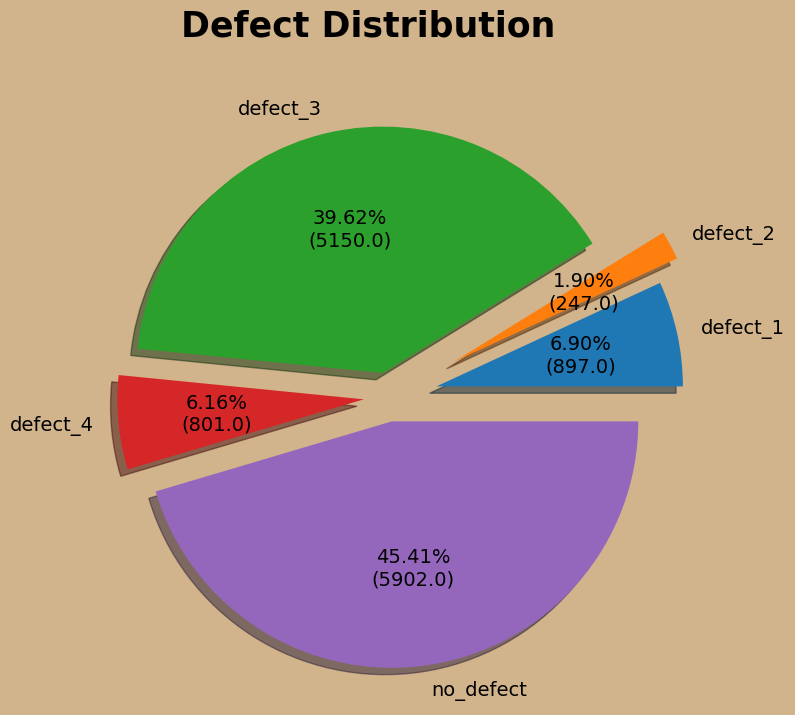

In [15]:
#https://www.askpython.com/python/plot-customize-pie-chart-in-python
defect_1,defect_2,defect_3,defect_4,no_defect=0,0,0,0,0
def func(v,p): #https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
  a=p*sum(v)/100
  return "{:.2f}%\n({:.1f})".format(p,a)
for i in range(len(train)):
  if train['rle_1'][i] != '':
    defect_1+=1
  if train['rle_2'][i] != '':
    defect_2+=1
  if train['rle_3'][i] != '':
    defect_3+=1
  if train['rle_4'][i] != '':
    defect_4+=1
  if train['defect'][i] == 0:
    no_defect+=1
labels=['defect_1','defect_2','defect_3','defect_4','no_defect']
sizes=[defect_1,defect_2,defect_3,defect_4,no_defect]
explode=(0.2,0.3,0.1,0.1,0.1)
fig,ax=plt.subplots(figsize=(16,8))
ax.pie(sizes,explode=explode,labels=labels,textprops={'fontsize': 14},autopct=lambda p: func(sizes,p),shadow=True)
fig.suptitle('Defect Distribution',fontsize=25,fontweight='bold')
fig.set_facecolor("tan")
plt.show()

In [16]:
def patch1(bar,ax):
  #https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
  for p in bar.patches:
     width=p.get_width()
     height=p.get_height()
     x,y=p.get_xy()
     ax.annotate('{}'.format(height),(x+width/2,y+height*1.02),ha='center',fontsize=14)

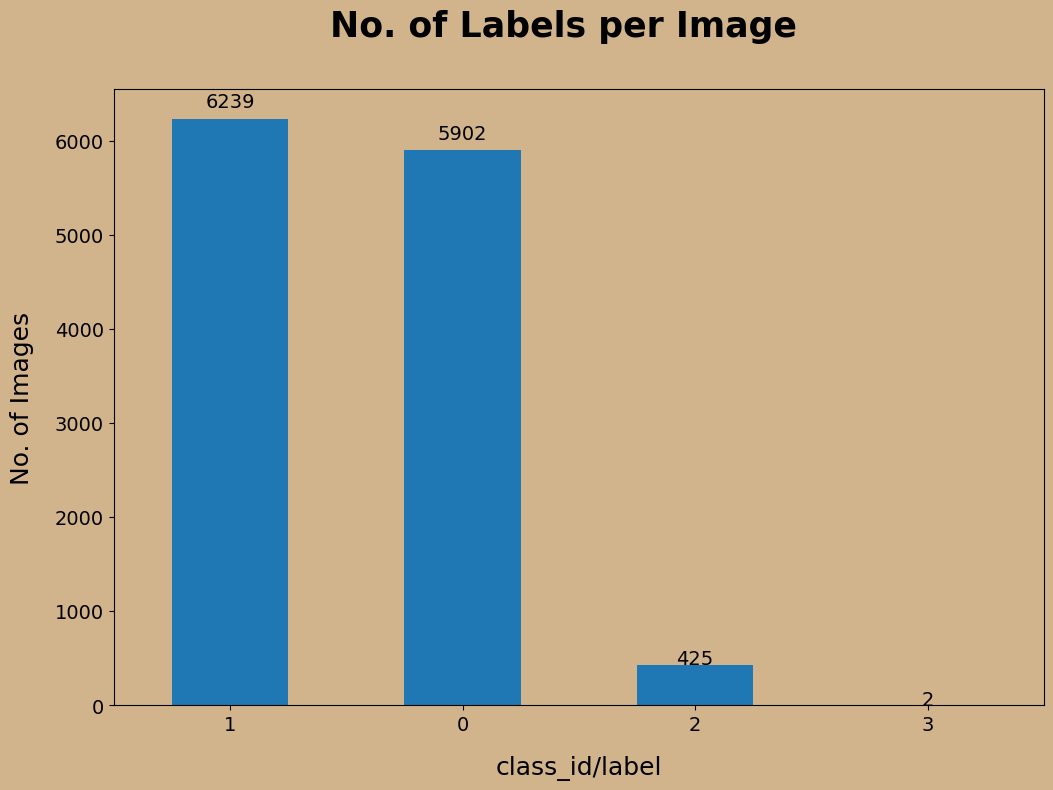

In [17]:
fig,ax=plt.subplots(figsize=(12,8))
a=train['total_defects'].value_counts().plot(kind='bar')
patch1(a,ax)
ax.set_xlabel("class_id/label",fontsize=18,labelpad=15)
ax.set_ylabel("No. of Images",fontsize=18,labelpad=15)
plt.xticks(rotation='horizontal',fontsize=14)
plt.yticks(fontsize=14)
fig.suptitle('No. of Labels per Image',fontsize=25,fontweight='bold')
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.show()

In [22]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle_to_mask(rle):
    # CONVERT RLE TO MASK
    if (pd.isnull(rle))|(rle=='')|(rle=='-1'):
        return np.zeros((256,1600) ,dtype=np.uint8)

    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])]=1

    return mask.reshape((height,width),order='F')

In [23]:
def plot_mask(rle_defect,k):
  x=rle_defect.columns[2]
  train_folder_path='/content/steel/train_images/'
  # Create figure and axes
  fig,ax=plt.subplots(4,2,figsize=(14,9))
  fig.suptitle('Defect_'+str(k)+'_Images',fontsize=20,fontweight='bold')
  for i in range(4):
    image_id=rle_defect['image_id'][i]
    rle=rle_defect[x][i]
    im=Image.open(train_folder_path+str(image_id))
    ax[i,0].imshow(im)
    ax[i,0].set_title(image_id)
    mask=rle_to_mask(rle)
    ax[i,1].imshow(mask)
    ax[i,1].set_title("Mask for "+str(image_id))
  fig.set_facecolor("tan")
  plt.show()

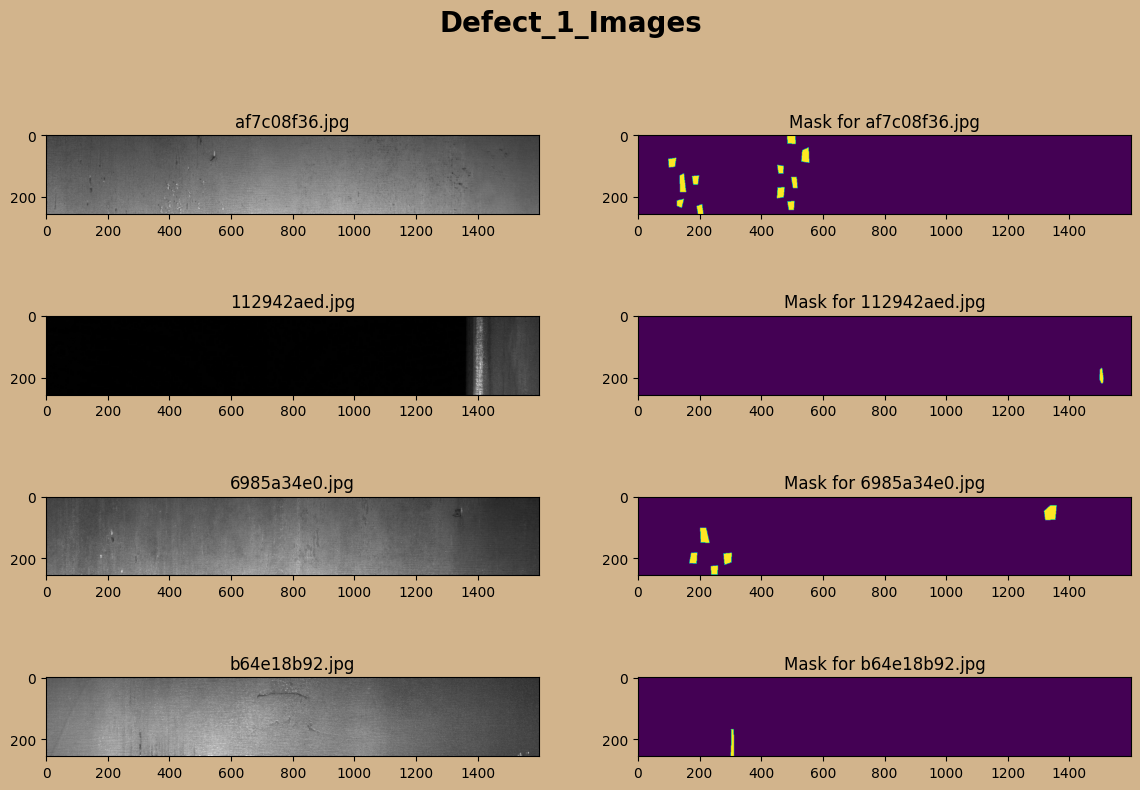

In [24]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
rle_defect=train[train['defect_1']==1]
rle_defect=rle_defect[['image_id','rle_1']]
rle_defect=rle_defect.sample(n=4)
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,1)

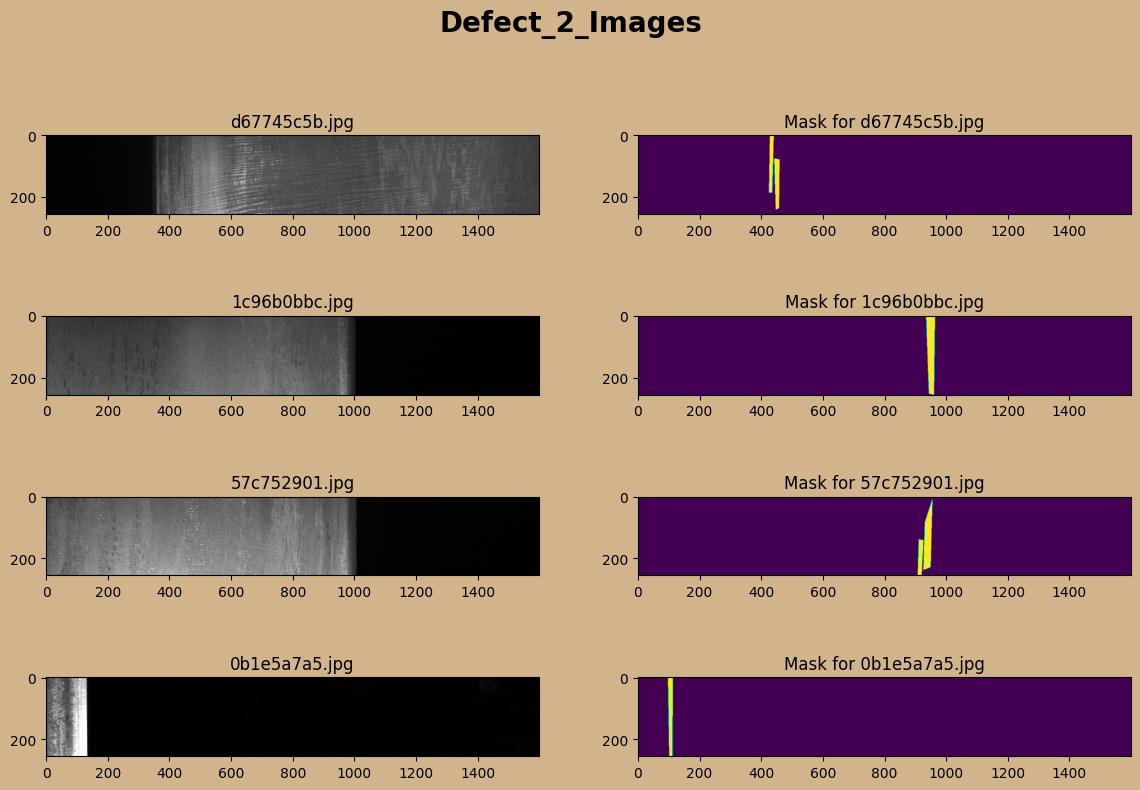

In [25]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
rle_defect=train[train['defect_2']==1]
rle_defect=rle_defect[['image_id','rle_2']]
rle_defect=rle_defect.sample(n=4)
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,2)

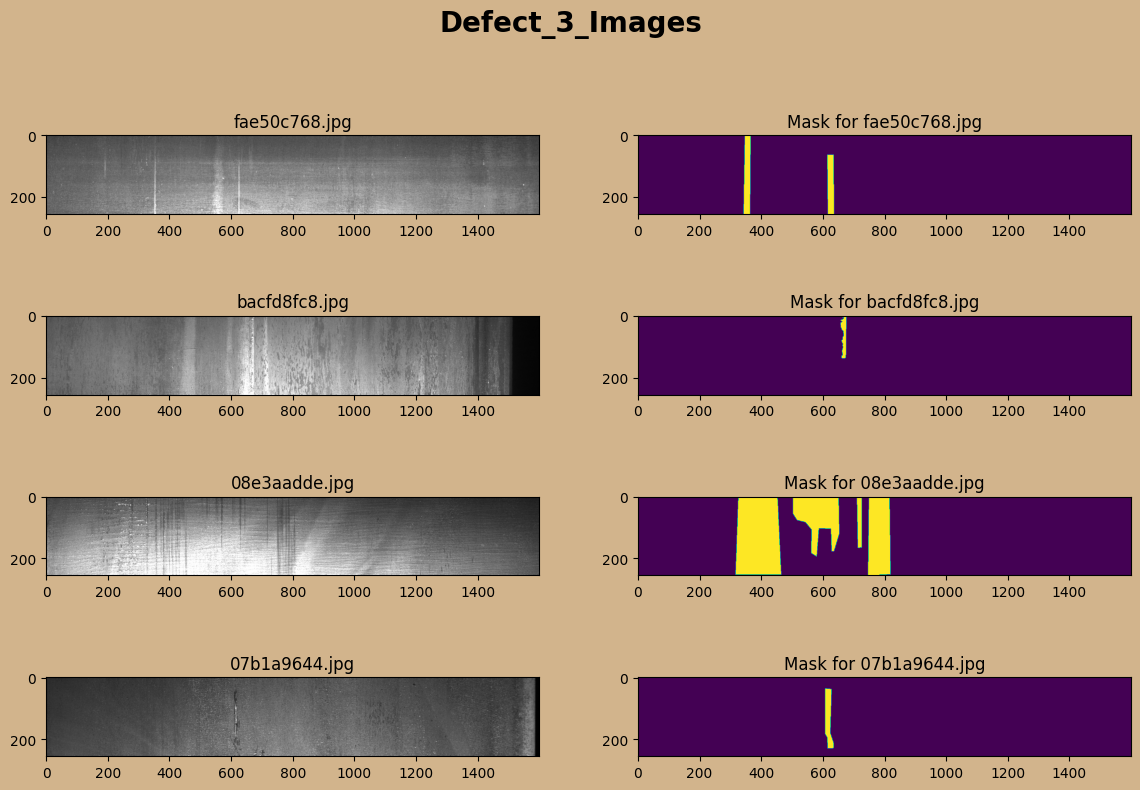

In [26]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
rle_defect=train[train['defect_3']==1]
rle_defect=rle_defect[['image_id','rle_3']]
rle_defect=rle_defect.sample(n=4)
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,3)

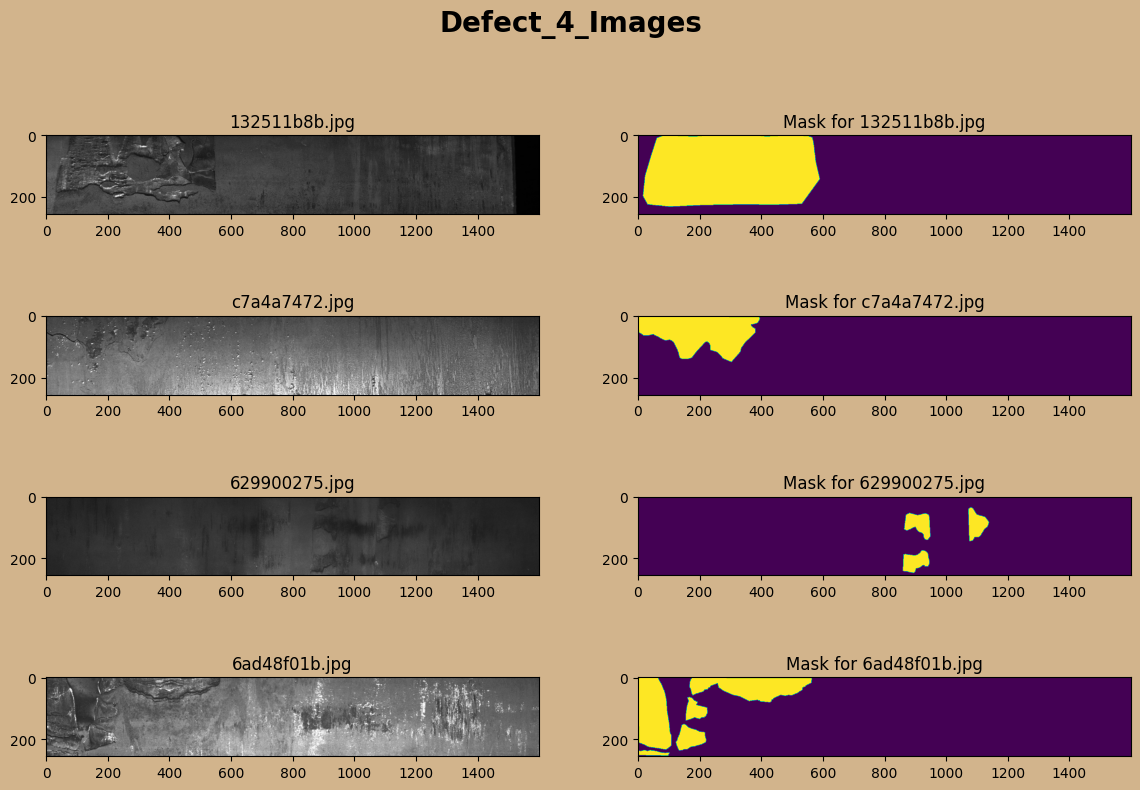

In [27]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
rle_defect=train[train['defect_4']==1]
rle_defect=rle_defect[['image_id','rle_4']]
rle_defect=rle_defect.sample(n=4)
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,4)

In [29]:
def mask_areas(rle_defect):
  area=[]
  for i in rle_defect:
    mask=np.sum(rle_to_mask(i))
    area.append(np.sum(rle_to_mask(i)))
  return area

In [30]:
rle_defect=train[train['defect_1']==1]
rle_defect=rle_defect['rle_1']
rle_1_area=mask_areas(rle_defect)

rle_defect=train[train['defect_2']==1]
rle_defect=rle_defect['rle_2']
rle_2_area=mask_areas(rle_defect)

rle_defect=train[train['defect_3']==1]
rle_defect=rle_defect['rle_3']
rle_3_area=mask_areas(rle_defect)

rle_defect=train[train['defect_4']==1]
rle_defect=rle_defect['rle_4']
rle_4_area=mask_areas(rle_defect)

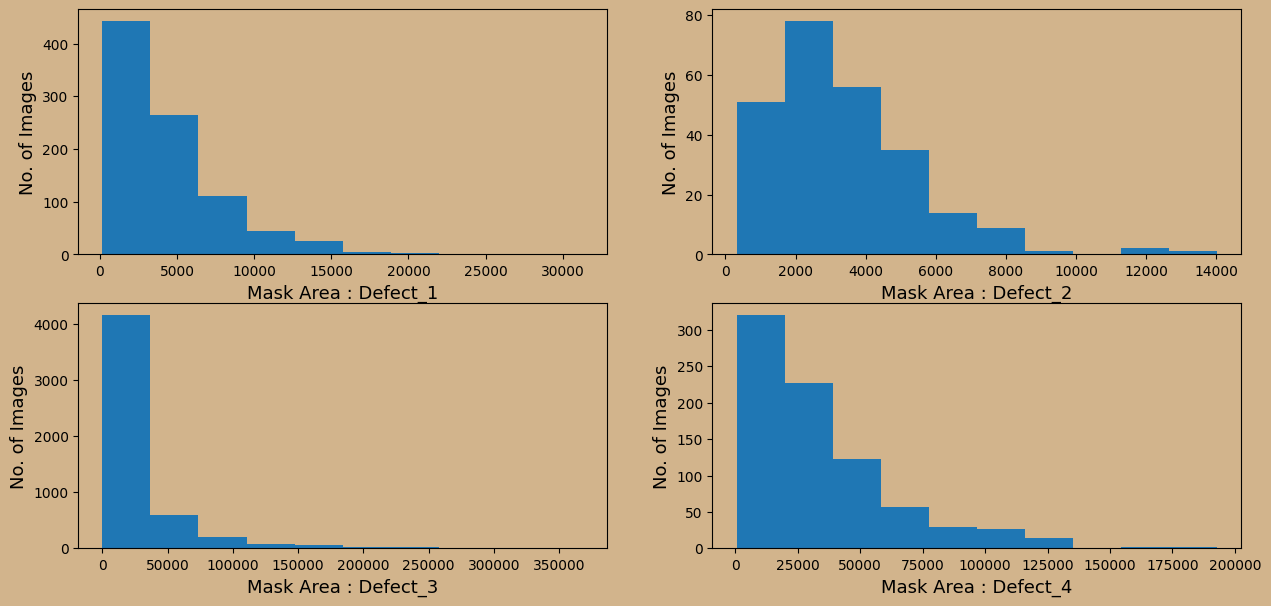

In [31]:
fig,ax=plt.subplots(2,2,figsize=(15,7))

ax[0,0].hist(x=rle_1_area)
ax[0,0].set_xlabel("Mask Area : Defect_1",fontsize=13)
ax[0,0].set_ylabel("No. of Images",fontsize=13)
ax[0,0].set_facecolor("tan")

ax[0,1].hist(x=rle_2_area)
ax[0,1].set_xlabel("Mask Area : Defect_2",fontsize=13)
ax[0,1].set_ylabel("No. of Images",fontsize=13)
ax[0,1].set_facecolor("tan")

ax[1,0].hist(x=rle_3_area)
ax[1,0].set_xlabel("Mask Area : Defect_3",fontsize=13)
ax[1,0].set_ylabel("No. of Images",fontsize=13)
ax[1,0].set_facecolor("tan")

ax[1,1].hist(x=rle_4_area)
ax[1,1].set_xlabel("Mask Area : Defect_4",fontsize=13)
ax[1,1].set_ylabel("No. of Images",fontsize=13)
ax[1,1].set_facecolor("tan")

fig.set_facecolor("tan")
plt.show()

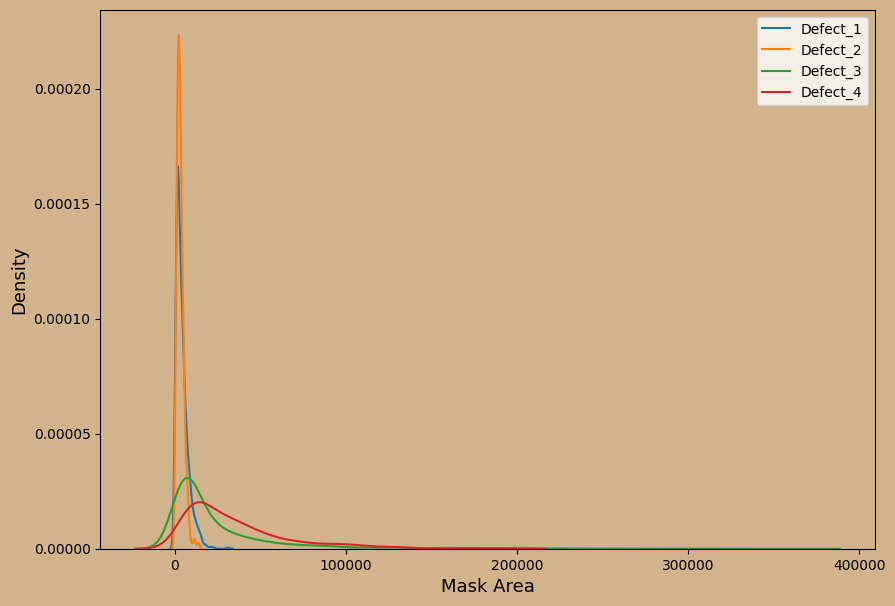

In [32]:
fig,ax=plt.subplots(figsize=(10,7))

sns.kdeplot(rle_1_area,label='Defect_1')
sns.kdeplot(rle_2_area,label='Defect_2')
sns.kdeplot(rle_3_area,label='Defect_3')
sns.kdeplot(rle_4_area,label='Defect_4')
plt.legend()
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.ylabel('Density',fontsize=13)
plt.xlabel('Mask Area',fontsize=13)
plt.show()

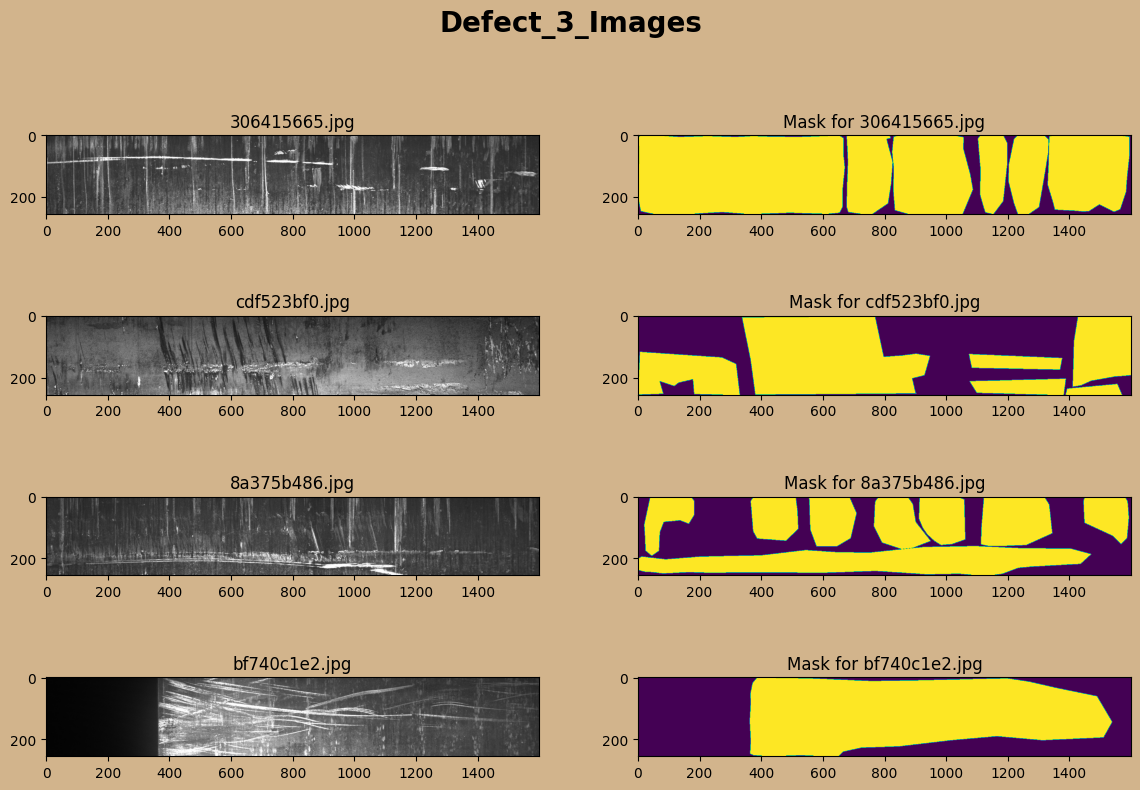

In [33]:
rle_defect=train[train['defect_3']==1]
rle=rle_defect['rle_3']
rle_3_area=mask_areas(rle)
rle_defect['rle_3_area']=rle_3_area
rle_defect=rle_defect[rle_defect['rle_3_area']>200000]
rle_defect=rle_defect[['image_id','rle_3']]
rle_defect=rle_defect.sample(n=4)
rle_defect=rle_defect.reset_index()
plot_mask(rle_defect,3)